# LDDMM in tensorflow
There are two computationally demanding challenges in Tensorflow.  Interpolation, and fft.  In tensorflow we will have to implement linear interpolation based on linear combinations of slicing.

I will start with a 2d implementation, then go to 3d.

## Importing stuff
I'll start by importing libraries and setting up

Standard numerics, reading neuroimages, and tensorflow, finding files

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion() # display during, note I can call fig.canvas.draw()
import tensorflow as tf
import nibabel as nib
import glob

## Getting images
Load some images

<IPython.core.display.Javascript object>


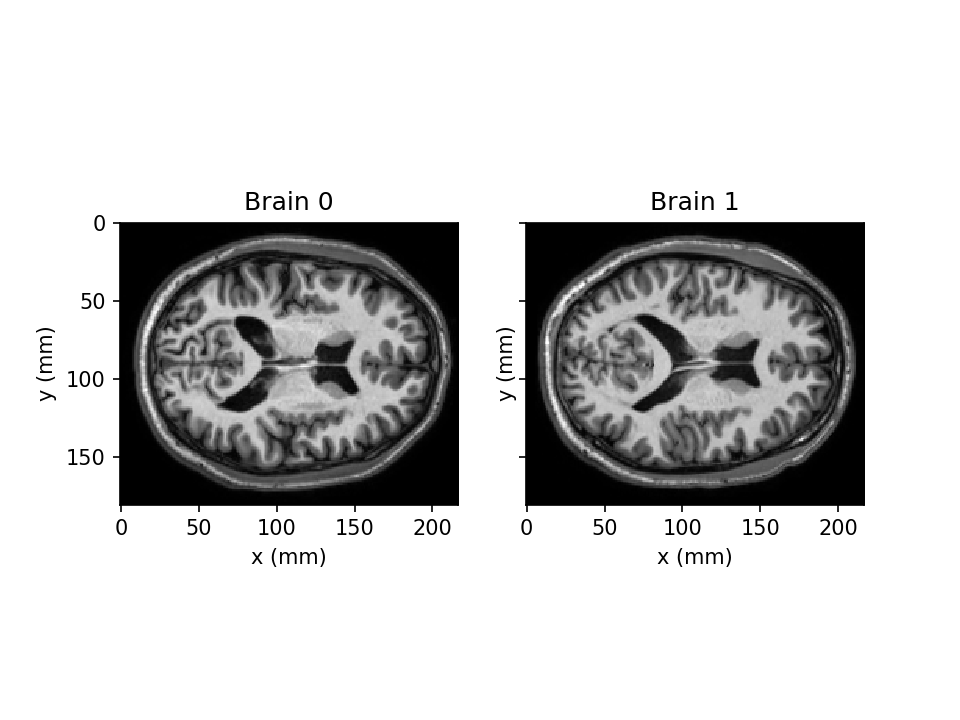

In [2]:
files = glob.glob('*MNI.img')
img0 = nib.load(files[0])
img1 = nib.load(files[1])
# some info
#print(dir(img0))
#print(img0.header)
nx = img0.header['dim'][1:4]
#print(nx)

dx = img0.header['pixdim'][1:4]
#print(dx)

x0 = np.arange(0,nx[0])*dx[0]
x1 = np.arange(0,nx[1])*dx[1]
x2 = np.arange(0,nx[2])*dx[2]
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)

#print(img0.shape)

# a picture
f,ax = plt.subplots(1,2,squeeze=True,sharex=True,sharey=True)
s = int(img0.shape[2]/2*0.96)
imshowargs = {'aspect':'equal', 'cmap':'gray', 'interpolation':'none'}
ax[0].imshow(np.squeeze(img0.get_data()[:,:,s]), **imshowargs)
ax[1].imshow(np.squeeze(img1.get_data()[:,:,s]), **imshowargs)

_ = [ (a.set_xlabel('x (mm)'), a.set_ylabel('y (mm)'), a.set_title('Brain {}'.format(i))) for i,a in enumerate(ax)]

## Get some 2D images
Get 2D images for my first test

In [3]:
I = img0.get_data()[:,:,s,0]
J = img1.get_data()[:,:,s,0]

## Make an example deformation


In [4]:
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
# identity transformation
id0 = X0
id1 = X1
# nonlinear
scale = 20.0
phi0 = id0 + np.exp(-(X0**2 + X1**2)/2.0/scale**2)*20
phi1 = id1

In [5]:
Itf = tf.get_variable('Itf',initializer=tf.constant_initializer(I),shape=nx[:2],
                             dtype=tf.float64, trainable=False)
Jtf = tf.get_variable('Jtf',initializer=tf.constant_initializer(J),shape=nx[:2],
                             dtype=tf.float64, trainable=False)
phi0tf = tf.get_variable('phi0tf',initializer=tf.constant_initializer(phi0),shape=nx[:2],
                         dtype=tf.float64, trainable=False)
phi1tf = tf.get_variable('phi1tf',initializer=tf.constant_initializer(phi1),shape=nx[:2],
                         dtype=tf.float64, trainable=False)
id0tf = tf.get_variable('id0tf',initializer=tf.constant_initializer(X0),shape=nx[:2],
                       dtype=tf.float64, trainable=False)
id1tf = tf.get_variable('id1tf',initializer=tf.constant_initializer(X1),shape=nx[:2],
                       dtype=tf.float64, trainable=False)

# now we need to start adding the operations
The first thing we will need to do is convert the transformations to indices

In [6]:
#convert to index
phi0_index = (phi0tf - x0[0])/dx[0]
phi1_index = (phi1tf - x1[0])/dx[2]
# take the floor to get integers
phi0_index_floor = tf.floor(phi0_index)
phi1_index_floor = tf.floor(phi1_index)
# get the fraction to the next pixel
phi0_p = phi0_index - phi0_index_floor
phi1_p = phi1_index - phi1_index_floor

In [7]:
# and then we need to get the next samples
phi0_index_floor_1 = phi0_index_floor+1
phi1_index_floor_1 = phi1_index_floor+1

In [8]:
# and apply boundary conditions
phi0_index_floor = tf.minimum(phi0_index_floor,nx[0]-1)
phi0_index_floor = tf.maximum(phi0_index_floor,0)

phi0_index_floor_1 = tf.minimum(phi0_index_floor_1,nx[0]-1)
phi0_index_floor_1 = tf.maximum(phi0_index_floor_1,0)

phi1_index_floor = tf.minimum(phi1_index_floor,nx[1]-1)
phi1_index_floor = tf.maximum(phi1_index_floor,0)

phi1_index_floor_1 = tf.minimum(phi1_index_floor_1,nx[1]-1)
phi1_index_floor_1 = tf.maximum(phi1_index_floor_1,0)

In [9]:
# then we will need to vectorize everything to use scalar indices
phi0_index_floor_flat = tf.reshape(phi0_index_floor,[-1])
phi0_index_floor_flat_1 = tf.reshape(phi0_index_floor_1,[-1])

phi1_index_floor_flat = tf.reshape(phi1_index_floor,[-1])
phi1_index_floor_flat_1 = tf.reshape(phi1_index_floor_1,[-1])

I_flat = tf.reshape(Itf,[-1])

In [10]:
# now we will combine into a scalar index
#phi_index_floor_flat = phi0_index_floor_flat + nx[0]*phi1_index_floor_flat
# the above does not work
# the below does work, but its odd
# okay the answer is simply that the LAST INDEX IS CONTIGUOUS
phi_index_floor_flat_00 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat
phi_index_floor_flat_01 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat_1
phi_index_floor_flat_10 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat
phi_index_floor_flat_11 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat_1





In [11]:
# now slice the image
I00_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_00, dtype=tf.int64))
I01_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_01, dtype=tf.int64))
I10_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_10, dtype=tf.int64))
I11_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_11, dtype=tf.int64))
# reshape it
I00 = tf.reshape(I00_flat,nx[:2])
I01 = tf.reshape(I01_flat,nx[:2])
I10 = tf.reshape(I10_flat,nx[:2])
I11 = tf.reshape(I11_flat,nx[:2])

# combine them!
Il = I00*(1.0-phi0_p)*(1.0-phi1_p) \
    + I01*(1.0-phi0_p)*(    phi1_p) \
    + I10*(    phi0_p)*(1.0-phi1_p) \
    + I11*(    phi0_p)*(    phi1_p)

In [12]:
# now start a session, and get I00
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #tf.initialize_variables([Itf,phi0tf,phi1tf])
    I00np = I00.eval()
    phishow = phi0_index_floor.eval()
    Ilnp = Il.eval()


<IPython.core.display.Javascript object>


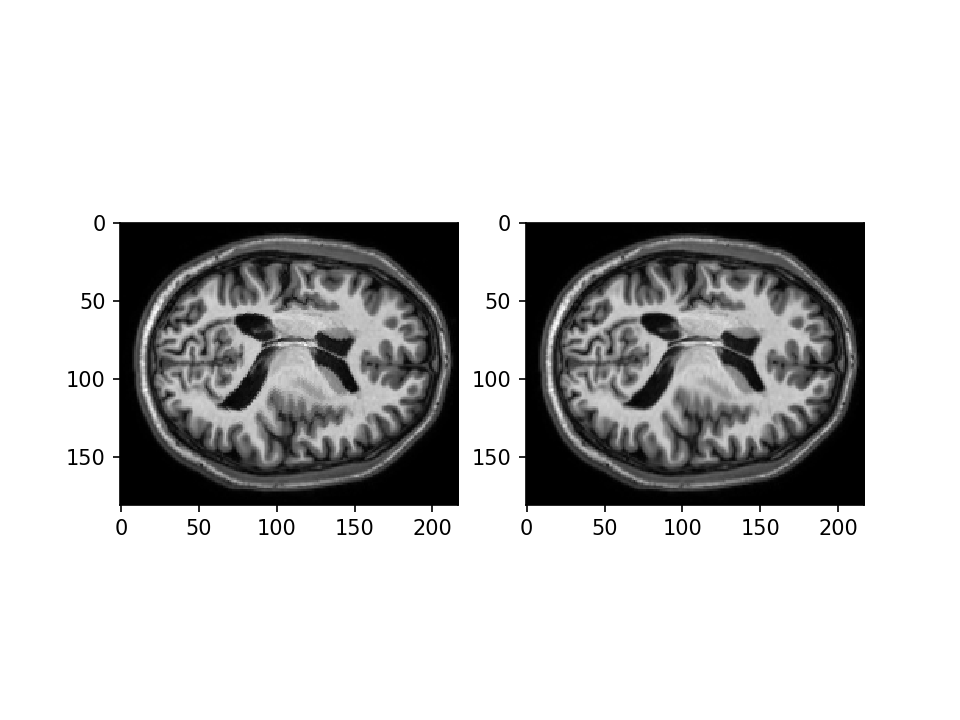

In [13]:
f,ax = plt.subplots(1,2)
ax[0].imshow(I00np,cmap='gray',aspect='equal')
ax[1].imshow(Ilnp,cmap='gray',aspect='equal')

## wrapping into a nice function
I will need to wrap this up into a nice function in order to use it meaningfully

The inputs will 

One issue is if I want to deform a bunch of things with the same deformation, can I do it more efficiently?

There should be a way to use gather like that on the last axis of a tensor or the first axis or something.

In [14]:
def interp2(x0,x1,Itf,phi0tf,phi1tf):
    ''' 
    inputs x0, x1 should be numpy arrays
    the rest should be tensorflow tensors
    '''
    # get the size
    dx = [x0[1]-x0[0], x1[1]-x1[0]]
    nx = [len(x0), len(x1)]    
    #convert to index
    phi0_index = (phi0tf - x0[0])/dx[0]
    phi1_index = (phi1tf - x1[0])/dx[1]
    # take the floor to get integers
    phi0_index_floor = tf.floor(phi0_index)
    phi1_index_floor = tf.floor(phi1_index)
    # get the fraction to the next pixel
    phi0_p = phi0_index - phi0_index_floor
    phi1_p = phi1_index - phi1_index_floor
    # get the next samples
    phi0_index_floor_1 = phi0_index_floor+1
    phi1_index_floor_1 = phi1_index_floor+1
    # and apply boundary conditions
    phi0_index_floor = tf.minimum(phi0_index_floor,nx[0]-1)
    phi0_index_floor = tf.maximum(phi0_index_floor,0)
    phi0_index_floor_1 = tf.minimum(phi0_index_floor_1,nx[0]-1)
    phi0_index_floor_1 = tf.maximum(phi0_index_floor_1,0)
    phi1_index_floor = tf.minimum(phi1_index_floor,nx[1]-1)
    phi1_index_floor = tf.maximum(phi1_index_floor,0)
    phi1_index_floor_1 = tf.minimum(phi1_index_floor_1,nx[1]-1)
    phi1_index_floor_1 = tf.maximum(phi1_index_floor_1,0)
    # then we will need to vectorize everything to use scalar indices
    phi0_index_floor_flat = tf.reshape(phi0_index_floor,[-1])
    phi0_index_floor_flat_1 = tf.reshape(phi0_index_floor_1,[-1])
    phi1_index_floor_flat = tf.reshape(phi1_index_floor,[-1])
    phi1_index_floor_flat_1 = tf.reshape(phi1_index_floor_1,[-1])
    I_flat = tf.reshape(Itf,[-1])
    # indices recall that the LAST INDEX IS CONTIGUOUS
    phi_index_floor_flat_00 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat
    phi_index_floor_flat_01 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat_1
    phi_index_floor_flat_10 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat
    phi_index_floor_flat_11 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat_1
    # now slice the image
    I00_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_00, dtype=tf.int64))
    I01_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_01, dtype=tf.int64))
    I10_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_10, dtype=tf.int64))
    I11_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_11, dtype=tf.int64))
    # reshape it
    I00 = tf.reshape(I00_flat,nx[:2])
    I01 = tf.reshape(I01_flat,nx[:2])
    I10 = tf.reshape(I10_flat,nx[:2])
    I11 = tf.reshape(I11_flat,nx[:2])
    # combine them!
    Il = I00*(1.0-phi0_p)*(1.0-phi1_p) \
        + I01*(1.0-phi0_p)*(    phi1_p) \
        + I10*(    phi0_p)*(1.0-phi1_p) \
        + I11*(    phi0_p)*(    phi1_p)
    return Il

<IPython.core.display.Javascript object>


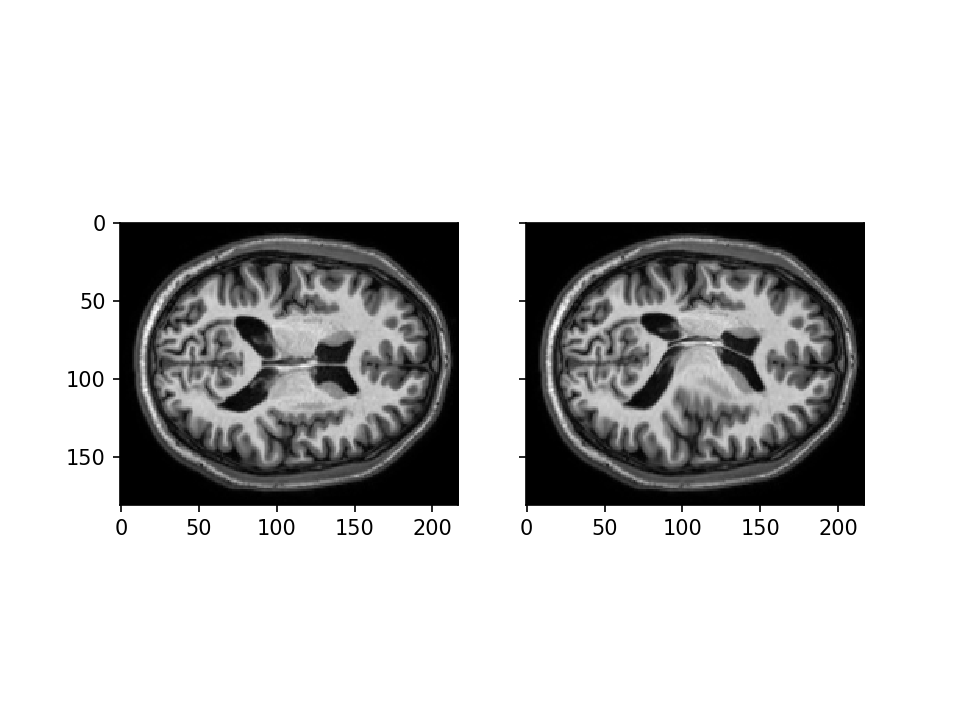

In [15]:
Il = interp2(x0,x1,Itf,phi0tf,phi1tf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Ilnp = Il.eval()
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(I,cmap='gray',aspect='equal',interpolation='none')
ax[1].imshow(Ilnp,cmap='gray',aspect='equal',interpolation='none')

<IPython.core.display.Javascript object>


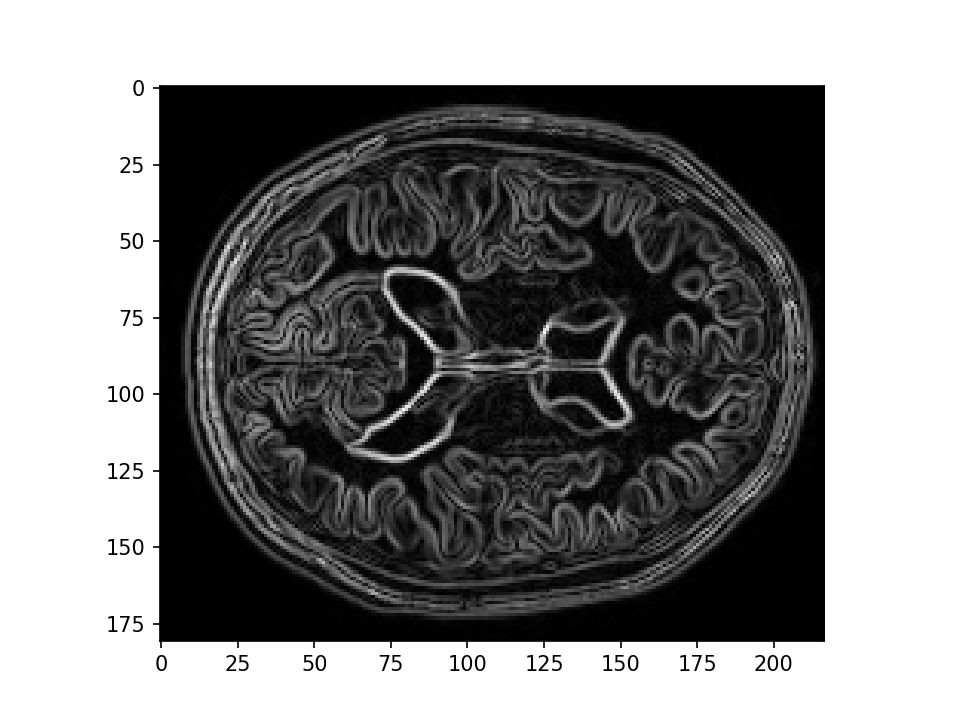

In [16]:
# we also will need gradients
def grad2d(Itf,dx):
    I_0 = (tf.manip.roll(Itf,shift=-1,axis=0) - tf.manip.roll(Itf,shift=1,axis=0))/2.0/dx[0]
    I_1 = (tf.manip.roll(Itf,shift=-1,axis=1) - tf.manip.roll(Itf,shift=1,axis=1))/2.0/dx[1]
    #out[0,:] = out[1,:]-out[0,:] # this doesn't work in tensorflow
    # generally you cannot assign to a tensor
    return I_0, I_1
I_0,I_1 = grad2d(Itf,dx)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    I_0np = I_0.eval()
    I_1np = I_1.eval()
plt.figure()
plt.imshow(np.sqrt(I_0np**2 + I_1np**2),cmap='gray',aspect='equal',interpolation='none')

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<IPython.core.display.Javascript object>


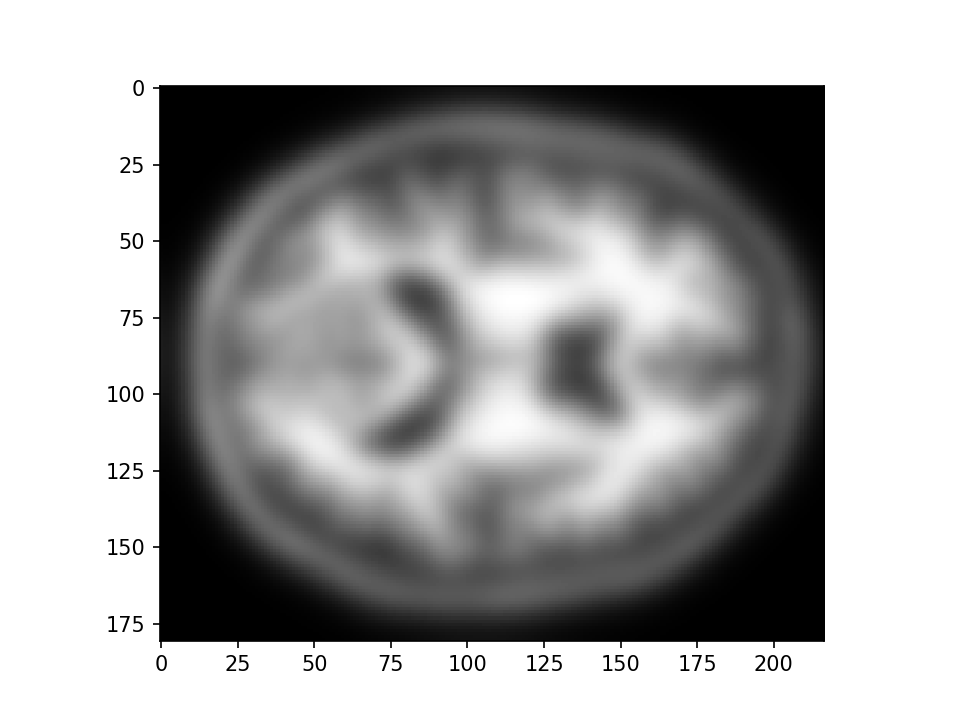

In [17]:
# last thing to test is ffts
alpha = 2.0*dx[0]
power = 2
f0 = np.arange(nx[0])/dx[0]/nx[0]
f1 = np.arange(nx[1])/dx[1]/nx[1]
F0,F1 = np.meshgrid(f0, f1, indexing='ij')
# smoothiing operator
# identity minus laplacian, in fourier domain
# AI[i,j] = I[i,j] - alpha^2( (I[i+1,j] - 2I[i,j] + I[i-1,j])/dx^2 + (I[i,j+1] - 2I[i,j] + I[i,j-1])/dy^2  )
Lhat = (1.0 - alpha**2*((-2.0 + 2.0*np.cos(2*np.pi*dx[0]*F0))/dx[0]**2 
    + (-2.0 + 2.0*np.cos(2*np.pi*dx[1]*F1))/dx[1]**2   ))**power
# for real ffts we only half of this, TODO
LLhat = Lhat**2
Khat = 1.0/LLhat
Khattf = tf.constant(Khat,dtype=tf.float64)
LLhattf = tf.constant(LLhat,dtype=tf.float64)

Ihat = tf.fft2d(tf.cast(Itf,tf.complex64))
Ibhat = Ihat*Khat
Ib = tf.real(tf.ifft2d(Ibhat))
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    Ibnp = Ib.eval()
plt.figure()
plt.imshow(Ibnp,cmap='gray',aspect='equal',interpolation='none')

## Now we're ready to implement LDDMM
So far the only thing I'm not satisfied with is the gradient

I will code one step, then I can run it

see pde example for nice idea https://www.tensorflow.org/tutorials/pdes

the graph will have to take v and compute vnew

then we'll assign vnew to v, and repeat the steps

In [18]:
# set some parameters
# these should probably be placeholders
nT = 5
dt = 1.0/nT
niter = 10
epsilon = 1e-1
sigmaM = 1e1
sigmaR = 1e3


In [19]:
# initialize some variables
# the v's are the only ones I really need to keep
vt0 = tf.get_variable('vt0',shape=[nx[0],nx[1],nT],dtype=tf.float64,trainable=False,initializer=tf.zeros_initializer())
vt1 = tf.get_variable('vt1',shape=[nx[0],nx[1],nT],dtype=tf.float64,trainable=False,initializer=tf.zeros_initializer())
vt0new = tf.get_variable('vt0new',shape=[nx[0],nx[1],nT],dtype=tf.float64,trainable=False,initializer=tf.zeros_initializer())
vt1new = tf.get_variable('vt1new',shape=[nx[0],nx[1],nT],dtype=tf.float64,trainable=False,initializer=tf.zeros_initializer())


In [20]:
# flow forwards
It = [Itf]
phiinv0 = id0tf
phiinv1 = id1tf
for t in range(nT):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    X0s = id0 - v0*dt
    X1s = id1 - v1*dt
    
    # update diffeomorphism with nice boundary conditions
    phiinv0 = interp2(x0,x1,phiinv0-id0,X0s,X1s)+X0s
    phiinv1 = interp2(x0,x1,phiinv1-id1,X0s,X1s)+X1s
    
    # deform the image
    It.append(interp2(x0,x1,Itf,phiinv0,phiinv1))
    
    # get regularization energy
    # to do
    
# now compute the error
lambda1 = (It[-1] - J)/tf.cast(sigmaM**2,tf.float64)

# get matching energy 
# to do

# flow the error backwards
phiinv0 = id0tf
phiinv1 = id1tf
vt0new_ = []
vt1new_ = []
for t in range(nT-1,-1,-1):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    X0s = id0 + v0*dt
    X1s = id1 + v1*dt
    phiinv0 = interp2(x0,x1,phiinv0-id0,X0s,X1s)+X0s
    phiinv1 = interp2(x0,x1,phiinv1-id1,X0s,X1s)+X1s
    
    # compute the gradient of the image at this time
    I_0,I_1 = grad2d(It[t],dx)
    
    # compute the determinanat of jacobian
    phiinv0_0,phiinv0_1 = grad2d(phiinv0,dx)
    phiinv1_0,phiinv1_1 = grad2d(phiinv1,dx)
    detjac = phiinv0_0*phiinv1_1 - phiinv0_1*phiinv1_0
    
    # get the lambda for this time
    lambda_ = interp2(x0,x1,lambda1,phiinv0,phiinv1)*detjac
    
    # set up the gradient
    grad0 = -lambda_*I_0
    grad1 = -lambda_*I_1
    
    # blur it
    grad0hat = tf.fft2d(tf.cast(grad0,tf.complex64))
    grad1hat = tf.fft2d(tf.cast(grad1,tf.complex64))
    grad0hat = grad0hat*tf.cast(Khattf,tf.complex64)
    grad1hat = grad1hat*tf.cast(Khattf,tf.complex64)
    grad0 = tf.real(tf.ifft2d(grad0hat))
    grad1 = tf.real(tf.ifft2d(grad1hat))
    # for whatever reason it became 32 bit
    grad0 = tf.cast(grad0,tf.float64)
    grad1 = tf.cast(grad1,tf.float64)
    
    # add the regularization
    grad0 = grad0 + v0
    grad1 = grad1 + v1
    
    # and calculate the new v
    vt0new_.append(v0 - epsilon*grad0)
    vt1new_.append(v1 - epsilon*grad1)
    
vt0new_ = vt0new_[::-1]
vt1new_ = vt1new_[::-1]
vt0new = tf.stack(vt0new_,axis=2)
vt1new = tf.stack(vt1new_,axis=2)


step = tf.group(
  vt0.assign(vt0new),
  vt1.assign(vt1new))


<IPython.core.display.Javascript object>


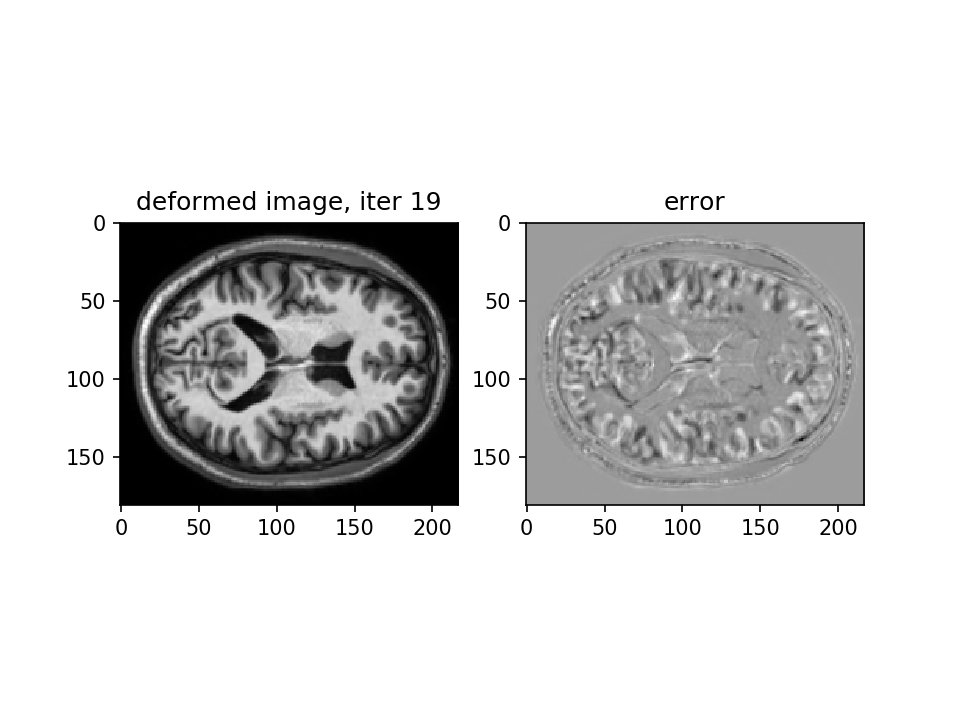

In [21]:
f,ax = plt.subplots(1,2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        step.run()
        Idnp = It[-1].eval()
        ax[0].imshow(Idnp,cmap='gray',aspect='equal',interpolation='none')
        ax[0].set_title('deformed image, iter {}'.format(i))
        lambda1np = lambda1.eval()
        ax[1].imshow(lambda1np,cmap='gray',aspect='equal',interpolation='none')
        ax[1].set_title('error')
        f.canvas.draw()
        
    

## to do
I think more and more variables will keep getting added to the graph as we iterate.  I will want to use get_variable more carefully

Well I'm not sure this is something I need to worry about.  the variables only get created once.  Then the graph updates itself.

So what I need to do is fix boundary conditions on the gradient.


And write the code in a nice way

And move to 3D